In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import pipeline
from transformers import BertForTokenClassification, AdamW

from seqeval.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_crfsuite import metrics
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tqdm import trange

import random

sns.set(style='darkgrid')

MAX_LEN = 250
batch_size = 2
EPOCHS = 3

Using TensorFlow backend.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [3]:
def clean_word(word):
    if word == '!!!':
        word = '!'
    if word == '...' or word == '..':
        word = '.'
    if word == '__':
        word = '_'
    if len(word) > 1 and '.' in word and word != '.':
        word = ''.join(word.split('.'))
    if word == '':
        word = '.'
    if word[-1] == '.' and word != '.':
        word = word[:-1]
    if word[-1] == '"' and word[0] == '"':
        word = word[1:-1]
    if not word.istitle():
        word = word.lower()
    if word == '--':
        word = '-'
    if '-' in word and word != '-':
        word = word.split('-')[0]
    if "'" in word and word != "'":
        word = ''.join(word.split("'"))
    if '’' in word and word != '’':
        word = ''.join(word.split('’'))
        
    return word

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=False)

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        word = clean_word(word)
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [5]:
def preprocess_sentences(data):
    res = []
    words = set()
    tags = set()
    sentences = []
    for s in tqdm(data):
        tmp_s = []
        tmp_t = []
        for word, tag in s:
            tmp_s.append(word)
            tmp_t.append(tag)
            words.add(word)
            tags.add(tag)

        sentences.append(' '.join([x for x in tmp_s]))
        res.append((tmp_s, tmp_t))
    return res, list(words), list(tags), sentences

In [6]:
class TransformerAugmenter():
    def __init__(self):
        self.num_sample_tokens = 5
        self.fill_mask = pipeline(
            "fill-mask",
            topk=self.num_sample_tokens,
            model="distilroberta-base"
        )
    
    def generate(self, sentence, num_replace_tokens=3):              
        augmented_sentence = sentence.copy()
        for i in range(num_replace_tokens):
            text = " ".join([w[0] for w in augmented_sentence])
            replace_token = random.choice(augmented_sentence)
            masked_text = text.replace(
                replace_token[0],
                f"{self.fill_mask.tokenizer.mask_token}",
                1            
            )
            res = self.fill_mask(masked_text)[random.choice(range(self.num_sample_tokens))]
            tmp_sentence, augmented_sentence = augmented_sentence.copy(), []
            for w in tmp_sentence:
                if w[0] == replace_token[0]:
                    augmented_sentence.append((res["token_str"].replace("Ġ", ""), w[1]))
                else:
                    augmented_sentence.append(w)
            text = " ".join([w[0] for w in augmented_sentence])
        return [sentence, augmented_sentence]

augmenter = TransformerAugmenter()

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def load_data(input_file):
    f = open(input_file)
    f.readline()
    sentences = []
    sentence = []
    for line in f:
        if line == "\n":
            sentences.append(sentence)
            sentence = []
        else:
            line_parts = line.strip().rsplit(",", 1)
            sentence.append(tuple(line_parts))
    sentences.append(sentence)
    return sentences

train = load_data("train.csv")
train_data,words, tags, sentences = preprocess_sentences(train)

In [8]:
test_data = []
test_df = pd.read_csv('test_sentences.csv').text
for i in test_df:
    test_data.append(i.split())

In [9]:
random.seed(18)
augmented_sentences = []
n_sentences = 3000
for sentence in tqdm(random.sample(train, n_sentences)):
    augmented_sentences.extend(augmenter.generate(sentence, num_replace_tokens=10))

train.extend(augmented_sentences)

In [10]:
sentences = [[word[0] for word in sentence] for sentence in train]
labels = [[s[1] for s in sentence] for sentence in train]

In [11]:
tag_values = tags
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [12]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [13]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [14]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [15]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=18, test_size=0.01)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=18, test_size=0.01)

In [16]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [17]:
model = BertForTokenClassification.from_pretrained(
    "bert-large-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-c

In [18]:
model.cuda();

In [19]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [20]:
max_grad_norm = 1.0

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.30626563468704593
Validation loss: 0.22629660313193242
Validation Accuracy: 0.9268884268884269
sequence_accuracy_score: 0.6147540983606558
Validation F1-Score: 0.7419900182573158 



/home/pfederov/DL/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


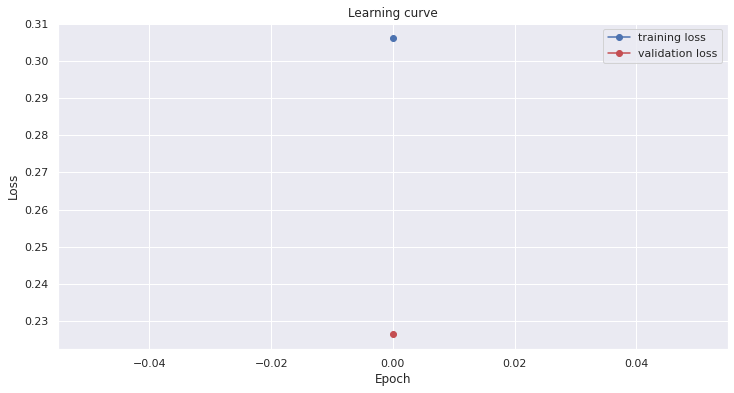

Epoch:  20%|██        | 1/5 [36:10<2:24:42, 2170.57s/it]

Average train loss: 0.14440448709481732
Validation loss: 0.17803105039018222
Validation Accuracy: 0.9604989604989606
sequence_accuracy_score: 0.7377049180327869
Validation F1-Score: 0.8469308761838706 



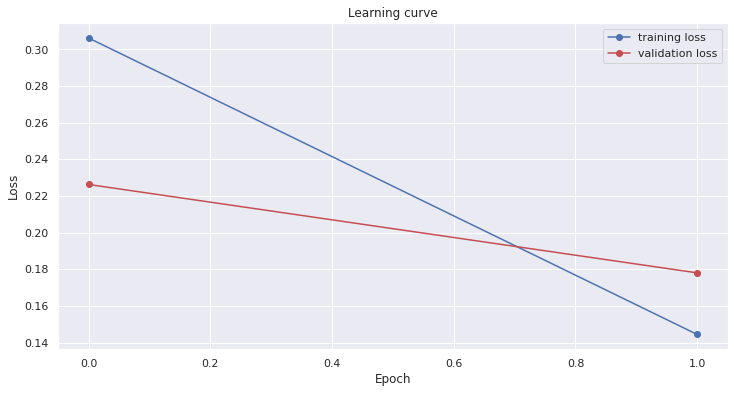

Epoch:  40%|████      | 2/5 [1:12:12<1:48:23, 2167.85s/it]

Average train loss: 0.07423545921555261
Validation loss: 0.2202073487309552
Validation Accuracy: 0.9643104643104643
sequence_accuracy_score: 0.7622950819672131
Validation F1-Score: 0.8483924689487522 



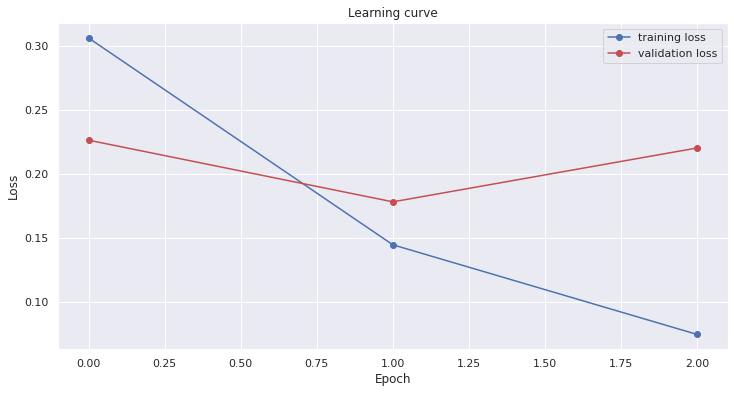

Epoch:  60%|██████    | 3/5 [1:48:01<1:12:04, 2162.23s/it]

Average train loss: 0.03826413789646726
Validation loss: 0.22628448043476845
Validation Accuracy: 0.9681219681219682
sequence_accuracy_score: 0.7622950819672131
Validation F1-Score: 0.8716913609064292 



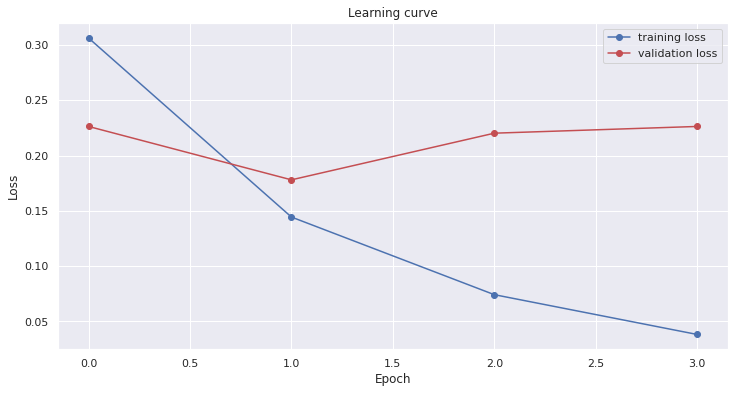

Epoch:  80%|████████  | 4/5 [2:23:43<35:56, 2156.36s/it]  

Average train loss: 0.020232338851192896
Validation loss: 0.22949150136646196
Validation Accuracy: 0.9722799722799723
sequence_accuracy_score: 0.7868852459016393
Validation F1-Score: 0.8833912545062369 



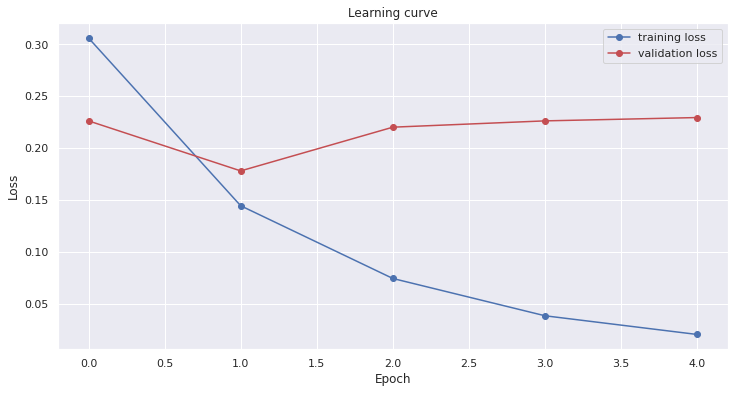

Epoch: 100%|██████████| 5/5 [2:59:20<00:00, 2152.16s/it]


In [22]:
loss_values, validation_loss_values = [], []
labels = tag_values.copy()
labels.remove('O')
labels.remove('PAD')

for ep in trange(EPOCHS, desc="Epoch"):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    loss_values.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    valid_tags = []
    for l in true_labels:
        tmp = []
        for l_i in l:
            if tag_values[l_i] != "PAD":
                tmp.append(tag_values[l_i])
        valid_tags.append(tmp)

    pred_tags = []
    for p, l in zip(predictions, true_labels):
        tmp = []
        for p_i, l_i in zip(p, l):
            if tag_values[l_i] != "PAD":
                tmp.append(tag_values[p_i])
        pred_tags.append(tmp)

    print('sequence_accuracy_score:', metrics.sequence_accuracy_score(pred_tags, valid_tags))
    print("Validation F1-Score: {} \n".format(metrics.flat_f1_score(pred_tags, valid_tags, average='weighted', labels=labels)))
    
    res = []
    for s in tqdm(test_data):
        tmp = []
        for w in s:
            w = clean_word(w)
            tmp.append(w)
        test_sentence = ' '.join(tmp)
        tokenized_sentence = tokenizer.encode(test_sentence)
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)
        tmp = []
        for token, label in zip(new_tokens, new_labels):
            if token != '[SEP]' and token != '[CLS]':
                tmp.append(label)
        res.append(' '.join(tmp))

    sub = pd.DataFrame(res).reset_index()
    sub.columns=['id', 'tag']
    sub.to_csv(f'submission_epoch_{ep}.csv', index=False)

    plt.rcParams["figure.figsize"] = (12,6)

    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")

    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
